In [56]:
import xarray as xr
import numpy as np
import pandas as pd
from numpy import datetime64
from ipywidgets import interact 
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import warnings
warnings.simplefilter('ignore')
from dask.diagnostics import ProgressBar
import matplotlib.cm as cm

In [309]:
#Custom functions and some extra requirements
from numpy.fft import fft, ifft, fftfreq, rfftfreq, rfft, irfft

#Returns the area to explore, along with feature names of the features with less than threshold percentage of nans.
def explore_nulls(cube,lat = -4.21, lon = -69.94, threshold = 25,spacing = 5):
    area_to_explore = cube.sel(lat = slice(lat+spacing,lat-spacing), lon = slice(lon-spacing,lon+spacing), time=slice('2001-01-05','2015-12-31'))
    snull = area_to_explore.isnull()
    nnull = area_to_explore.notnull()
    viable_features=[]
    for i in area_to_explore.keys():
        count_null = snull[i].values.sum()
        count_nnull = nnull[i].values.sum()
        null_percentage = count_null/(count_null+count_nnull)*100
        if(null_percentage <= threshold):
            #print(i, "null_percentage = {:.2f}".format(null_percentage))
            viable_features.append(i)
    return area_to_explore, viable_features

#Authored by SaumyaBansal, lists the N highest values of a list
def Nmax(list1, N = 5): 
    final_list = [] 
    
    for i in range(0, N):  
        max1 = 0
        for j in range(len(list1)):      
            if list1[j] > max1: 
                max1 = list1[j];
        list1.remove(max1); 
        final_list.append(max1) 
    return final_list
    
#Find the indexes corresponding to the position of the values of list_of_max in array.
def find_Index(array,list_of_max):
    indexes = []
    for i in range(len(list_of_max)):
            indexes.append(np.argwhere(array == list_of_max[i])[0][0])
    return indexes    


#Makes zero the Fourier coefficients of farray bigger than  thethreshold.
def clean_periodicity(farray, list_of_maxes, list_of_indexes, threshold = 5):
    for i in range(len(list_of_maxes)):
        if(list_of_maxes[i]> threshold):
            farray[list_of_indexes[i]] = 0
            
            
#Returns a pandas DataFrame with the seasonality-corrected viable features.
def clean_cube(cube, central_lat, central_lon, spacing, threshold = 25):
    cube_section, features = explore_nulls(cube.drop(["lat_bnds", "lon_bnds", "time_bnds","burn_date"]),lat = central_lat, lon = central_lon,threshold = threshold,spacing = spacing)
    series = []
    cube_section.load() #RAM expensive, avoid large spacing values.
    df = pd.DataFrame()
    df['Dates'] = np.datetime_as_string(cube_section[features[0]].dropna(dim='time').coords['time'].values,unit = 'D')
    for feature in features:
        print(feature)
        #series.append(clean_feature(cube_section, feature))
        df[feature] = clean_feature(cube_section,feature)
    
    return df
    #return pd.concat(series, axis=1)
    #return series

# panda Series with the spatial median of the corrected feature.
def clean_feature(cube_section, feature_name, fourier_threshold = 8):
    time_Series = cube_section[feature_name].dropna(dim='time').median(dim=['lat','lon'],skipna=True)
    time_Series = (time_Series-np.mean(time_Series))/np.std(time_Series) #estandarizar
    freq = rfftfreq(len(time_Series.values), d=8.0) #Frequencies to use. Cycles/days, sample rate is 1/8 days 
    f_time_Series = rfft(time_Series)
    
    real_maxes = Nmax(np.abs(f_time_Series.real).tolist())
    imag_maxes= Nmax(np.abs(f_time_Series.imag).tolist())
    real_ii = find_Index(np.abs(f_time_Series.real), real_maxes)
    imag_ii = find_Index(np.abs(f_time_Series.imag), imag_maxes)
    
    clean_periodicity(f_time_Series.real,real_maxes,real_ii)
    clean_periodicity(f_time_Series.imag,imag_maxes,imag_ii)
    
    corrected_time_Series = irfft(f_time_Series, n = len(time_Series))

    #Creates a new series 
    final_Series = pd.Series(corrected_time_Series)
    dates = np.datetime_as_string(cube_section[feature_name].dropna(dim='time').coords['time'].values,unit = 'Y')
    final_Series.index = dates
    
    return final_Series.values

In [313]:
lat = -0.041
lon = -67.0

hail_Satan, features = explore_nulls(cube_high_res,lat = lat, lon = lon, threshold = 0,spacing = 1)


In [316]:
freq = fftfreq(len(hail_Satan["evapotranspiration"]), d=8)
#freq[:205]**-1
test = hail_Satan['evapotranspiration'].values
test = normalize(test)
ft = fft(test)
aft = np.abs(ft)
maxIndex = 200
percent = aft[:maxIndex]*100/np.sum(aft[:maxIndex])
#plt.plot(freq[:maxIndex],percent)
print((np.mean(percent)+3*np.std(percent)))
#plt.plot(freq,aft)

0.005837994623958015


In [305]:
maxes = Nmax(list(percent),N=10)
indexes = find_Index(percent,maxes)
print(np.sum(maxes))
maxes,indexes,freq[indexes]**-1/28

10.173403009524682


([1.1010407536821496,
  1.0585694671989407,
  1.0449812643351277,
  1.0262176652645956,
  1.0187110369608314,
  1.0049247193892186,
  0.9936841300139055,
  0.9930883697539377,
  0.9914978813868668,
  0.9406877215391074],
 [180, 14, 103, 60, 112, 85, 92, 13, 75, 178],
 array([ 1.0952381 , 14.08163265,  1.91400832,  3.28571429,  1.76020408,
         2.31932773,  2.14285714, 15.16483516,  2.62857143,  1.10754414]))

2.129264748422818

In [142]:
hail_Satan

,Dates,bihemispheric_reflectance_near_infrared,bihemispheric_reflectance_shortwave,directional_hemispheric_reflectance_near_infrared,directional_hemispheric_reflectance_shortwave,directional_hemispheric_reflectance_visible,enhanced_vegetation_index_terra,evapotranspiration,gross_primary_productivity,normalized_difference_vegetation_index_terra,precipipation_chirps,surface_downwelling_photosynthetic_radiative_flux,vegetation_cover_fraction_no_vegetation,vegetation_cover_fraction_non_tree_vegetation,vegetation_cover_fraction_trees
0,2001-01-05,1.187733,0.888526,0.606960,0.810132,0.422814,-0.395339,-0.630803,0.480427,0.597147,-0.712187,-0.249881,-0.597300,1.277248,-1.422709
1,2001-01-13,1.020332,0.934901,0.836713,0.905526,0.400597,-0.010151,0.459284,-0.376597,0.783204,-0.340741,0.619059,-0.571486,1.233851,-1.348369
2,2001-01-21,0.880178,0.820166,1.146379,1.145906,0.531918,-1.527798,-0.985406,-0.221166,-4.141899,-0.007473,-1.923703,-0.546801,1.190591,-1.273605
3,2001-01-29,0.519305,0.579670,1.245322,1.213461,0.633343,-1.547089,0.311384,0.829736,-4.032184,0.125863,0.391055,-0.523293,1.147505,-1.198684
4,2001-02-06,0.554921,0.526563,1.216990,1.102938,0.464596,-0.114807,-0.848739,-0.497538,-0.128635,0.223388,-1.279154,-0.500990,1.104625,-1.123868
5,2001-02-14,0.732639,0.396004,1.123488,0.611152,-0.213931,-0.149638,0.119082,0.087948,-0.129449,-0.154938,0.055943,-0.479905,1.061972,-1.049414
6,2001-02-22,0.922975,0.422454,1.375117,0.722907,-0.432617,-0.408298,-0.425709,0.494576,-2.079579,-0.314563,-0.571485,-0.460037,1.019566,-0.975567
7,2001-03-02,1.118501,0.456743,1.436735,0.749869,-0.597512,-0.650135,-0.919470,-0.164303,-2.186698,-0.455353,-0.945663,-0.441367,0.977416,-0.902566
8,2001-03-10,1.311082,0.533753,1.469739,0.679419,-0.857539,0.292248,1.176229,-0.113987,1.699879,-0.261766,1.153023,-0.423864,0.935528,-0.830634
9,2001-03-18,1.247442,0.684913,1.468081,0.673522,-0.899992,0.344324,-0.103306,0.329327,1.524722,0.004852,-0.366972,-0.407483,0.893900,-0.759982


In [73]:
from esdl.cube_store import CubesStore
cs = CubesStore()
#cs

In [74]:
#cube_high_res = xr.open_zarr("/home/jovyan/work/datacube/ESDCv2.0.0/esdc-8d-0.083deg-184x270x270-2.0.0.zarr")
#cube_high_res = cs['CUBE_V2.0.0_global_time_optimized_0.083deg']
#cube_low_res = xr.open_zarr("/home/jovyan/work/datacube/ESDCv2.0.0/esdc-8d-0.25deg-184x90x90-2.0.0.zarr")
#cube_low_res = cs['CUBE_V2.0.0_global_time_optimized_0.25deg']
#cube_high_res = cs['CUBE_V2.0.0_global_time_optimized_0.25deg']
cube_high_res= cs["CUBE_V2.0.1_colombia_time_optimized_0.083deg"]

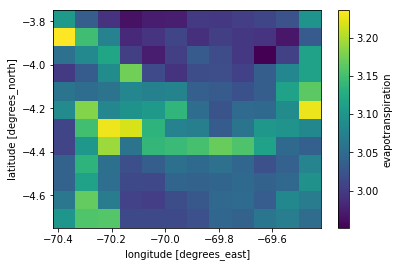

In [78]:
colombia.evapotranspiration.dropna(dim='time').mean(dim='time').plot()

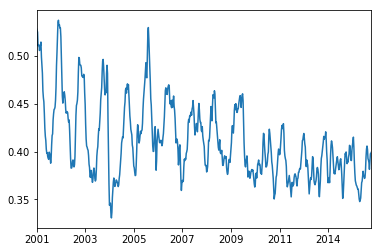

In [80]:
#By default xarray uses dask arrays. Sadly, dask does not have an implementation of median
testSeries = pd.Series(np.median(test[features[0]].dropna(dim='time'),axis=[1,2]))
dates = np.datetime_as_string(test[features[0]].dropna(dim='time').coords['time'].values,unit = 'Y')
testSeries.index = dates
testSeries.plot()

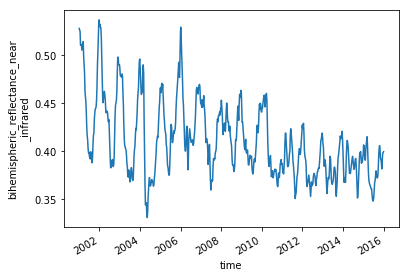

In [81]:
#It is possible to force xarray to not use dask array, using dataset.load(). It is RAM expensive.
test.load()
test[features[0]].dropna(dim='time').median(dim=['lat','lon'],skipna=True).plot()
#test[features[2]].median(dim=['lat','lon']).dropna(dim='time').plot()

In [82]:
len(test[features[0]].dropna(dim='time').median(dim=['lat','lon'],skipna=True))

690

19.71428571428571

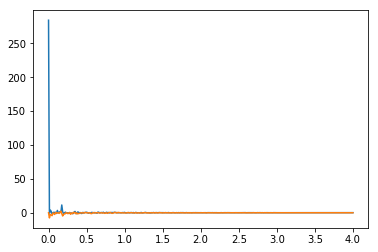

In [83]:
#First a particular case.
try0 = test[features[0]].dropna(dim='time').median(dim=['lat','lon'],skipna=True) #median on the small square
freq = rfftfreq(len(try0.values), d=1/8.0) #Frequencies to use. Cycles/days, sample rate is 1/8 days 
ftry0 = rfft(try0)
plt.plot(freq,ftry0.real)
plt.plot(freq,ftry0.imag)
freq[35]**-1*8

In [ ]:
maxesR= Nmax(np.abs(ftry0.real).tolist())
maxesI= Nmax(np.abs(ftry0.imag).tolist())
iiR = find_Index(np.abs(ftry0.real), maxesR)
iiI = find_Index(np.abs(ftry0.imag), maxesI)
maxesR, iiR

In [ ]:
clean_periodicity(ftry0.real,maxesR,iiR)
clean_periodicity(ftry0.imag,maxesI,iiI)

In [ ]:
#Plots the new Fourier space
plt.plot(freq,ftry0.real)
plt.plot(freq,ftry0.imag)
#plt.xlim(0.165,0.18)
freq[5]**-1*8

In [ ]:
#Inverse transforms the new Fourier space.
try0_result = irfft(ftry0, n = len(try0))

#Creates a new series for easy plotting
testSeries2 = pd.Series(try0_result)
dates = np.datetime_as_string(test[features[0]].dropna(dim='time').coords['time'].values,unit = 'Y')
testSeries2.index = dates
testSeries2.plot() #Seasonality corrected (blue)
(testSeries-np.mean(try0.values)).plot() #without correction (orange). I substracted the mean for easy comparision.



In [114]:
#The plan is to create a pandas DataFrame to store the seasonally corrected section of the cube.
amazon, features = explore_nulls(cube_high_res,spacing=1, threshold=0)#Default centered in Leticia.
amazon.load()
features[0]

'bihemispheric_reflectance_near_infrared'

In [115]:
def normalize(x):
    return (x-np.mean(x))/np.std(x)

In [121]:
corrected = clean_feature(amazon, features[5])
#corrected.plot()
#corrected
#corrected.apply(normalize)

In [122]:
lat = -4.21
lon = -69.94

hail_Satan = clean_cube(cube_high_res, central_lat=lat, central_lon=lon, spacing = 1,threshold=0)


bihemispheric_reflectance_near_infrared
bihemispheric_reflectance_shortwave
burn_date
directional_hemispheric_reflectance_near_infrared
directional_hemispheric_reflectance_shortwave
directional_hemispheric_reflectance_visible
enhanced_vegetation_index_terra
evapotranspiration
gross_primary_productivity
lat_bnds


ValueError: time must be a single dataset dimension

In [40]:
type(hail_Satan)

list

In [44]:
for sat in hail_Satan:
    print(sat.shape)


(1610,)
(1610,)
(1610,)
(1611,)
(1610,)


In [9]:
df = pd.concat(hail_Satan, axis=0)

In [12]:
df = pd.DataFrame([hail_Satan])

In [13]:
df

,0,1,2,3,4
0,1982 0.005180 1982 0.007684 1982 0.01...,1982 0.055874 1982 0.055205 1982 0.06...,1982 0.060170 1982 0.078238 1982 0.10...,1980 -0.662540 1980 -2.667771 1980 0...,1982 0.005219 1982 0.010268 1982 0.01...


In [14]:
df.set_index(dates)

NameError: name 'dates' is not defined

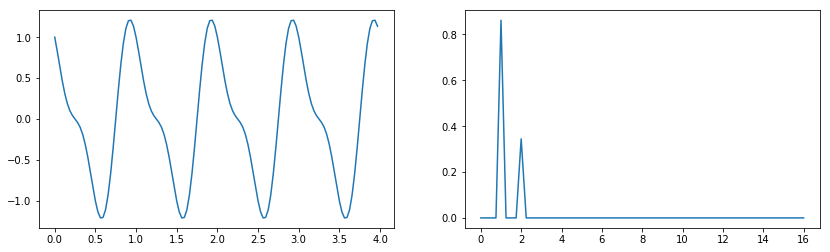

In [46]:
n = 128 # number of point in the whole interval
f = 1.0 #  frequency in Hz
dt = 1 / (f * 32 ) #32 samples per unit frequency
x = np.linspace( 0, (n-1)*dt, n)
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(14,4))
y = np.cos(2 * np.pi * x) - 0.4 * np.sin(2 * np.pi * 2 * x )
ax1.plot(x,y)
fy = rfft(y)
fx = rfftfreq(len(y),d=x[1]-x[0])
ax2.plot(fx,np.abs(fy)/sum(fy))